### BS6206 Use Case 1

Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve

In [2]:
df = pd.read_excel("E:/NTU/Course/6206/W1/data/IEDB.xlsx", engine="openpyxl")
df = df[['Reference - PMID','Reference - Date','Epitope - Name','Epitope - Species','MHC Restriction - Name','MHC Restriction - Class','Assay - Qualitative Measurement']]
df.head()

,Reference - PMID,Reference - Date,Epitope - Name,Epitope - Species,MHC Restriction - Name,MHC Restriction - Class,Assay - Qualitative Measurement
0,15259019.0,2004,SEFAYGSFVRTVSL,Mycobacterium tuberculosis,HLA-DR1,II,Positive-High
1,15259019.0,2004,SEFAYGSFVRTVSL,Mycobacterium tuberculosis,HLA-DR15,II,Positive-High
2,15259019.0,2004,SEFAYGSFVRTVSL,Mycobacterium tuberculosis,HLA-DR11,II,Positive-High
3,15259019.0,2004,SEFAYGSFVRTVSL,Mycobacterium tuberculosis,HLA-DR13,II,Positive-High
4,15259019.0,2004,SEFAYGSFVRTVSL,Mycobacterium tuberculosis,HLA-DR7,II,Positive-High


In [3]:
df.shape

(1048575, 7)

In [22]:
df_filtered.isnull().any()  # False: No missing values

Reference - PMID                    True
Reference - Date                   False
Epitope - Name                     False
Epitope - Species                   True
MHC Restriction - Name             False
MHC Restriction - Class            False
Assay - Qualitative Measurement    False
dtype: bool

In [20]:
# MHC Restriction-Class is all type II. Epitope-Name has no missing value

# Duplicate Epitope_Name. Only keep the first one
df_filtered = df.drop_duplicates(subset=["Epitope - Name"], keep="first")

# Filter out rows where peptide length is between 13 and 17
df_filtered = df_filtered[(df_filtered["Epitope - Name"].str.len() >= 13) & (df_filtered["Epitope - Name"].str.len() <= 17)]

In [40]:
df_filtered.shape

(209606, 7)

In [23]:
# Extract peptides containing only valid aa
epitopes = df_filtered['Epitope - Name']
epitopes = epitopes[epitopes.apply(lambda seq: '+' not in seq)]
valid_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")
epitopes = epitopes[epitopes.apply(lambda seq: set(seq.upper()).issubset(valid_amino_acids))]

In [51]:
df_filtered = df_filtered[df_filtered["Epitope - Name"].isin(epitopes)]  # Uniform the number of rows

In [52]:
df_filtered.shape

(209555, 7)

In [24]:
epitopes.shape

(209555,)

In [26]:
# For netmhciipan
output_file = "E:/360Downloads/Software/WSL/netMHCpan/netMHCIIpan-4.3/input_w10.fasta"

fasta_records = [
    SeqRecord(Seq(epitope), id=f"Epitope_{i+1}", description="")
    for i, epitope in enumerate(epitopes)
]

with open(output_file, "w") as f:
    SeqIO.write(fasta_records, f, "fasta")

In [25]:
# For pred
epitopes.to_csv("E:/NTU/Course/6206/W10/input_epitopes.txt", index=False, header=False)

In [ ]:
# netmhciipan code
cd /mnt/e/360Downloads/Software/WSL/netMHCpan/netMHCIIpan-4.3
./netMHCIIpan -a DRB1_1501,HLA-DQA10101-DQB10301,HLA-DPA10103-DPB10401 -f input_w10.fasta -xls -xlsfile W10/net_new.txt -BA -inptype 1

Evaluation

In [38]:
output_net = pd.read_csv("E:/NTU/Course/6206/W10/new_input/output_net_new.csv", sep=",", skiprows=1)
output_net.head()

,Pos,Peptide,ID,Target,Core,Inverted,Score,Rank_DRB1_1501,Score_BA,nM_DRB1_1501,...,Rank_BA.1,Core.2,Inverted.2,Score.2,Rank_HLA-DQA10101-DQB10301,Score_BA.2,nM_HLA-DQA10101-DQB10301,Rank_BA.2,Ave,NB
0,1,SEFAYGSFVRTVSL,Sequence,NaN,EFAYGSFVR,0,0.000499,68.457947,0.318912,1586.397217,...,0.232896,FAYGSFVRT,0,0.001306,33.781250,0.343816,1211.682251,10.247313,0.284690,1
1,2,EKAKYEAYKAAAAAA,Sequence,NaN,YEAYKAAAA,0,0.822854,0.526164,0.530978,159.926407,...,46.033318,YEAYKAAAA,0,0.104651,0.024849,0.428067,486.963226,1.441435,0.355677,3
2,3,EKPKYEAYKAAAAPA,Sequence,NaN,YEAYKAAAA,0,0.854878,0.430674,0.471675,303.796753,...,57.402584,YEAYKAAAA,0,0.135533,0.009994,0.399923,660.304077,3.021549,0.397063,3
3,4,EKPKFEAYKAAAAPA,Sequence,NaN,FEAYKAAAA,0,0.939545,0.184978,0.616695,63.261395,...,39.918716,FEAYKAAAA,0,0.105391,0.024275,0.421433,523.201660,1.733997,0.421707,3
4,5,EKAKEEAYKAAAAAA,Sequence,NaN,EEAYKAAAA,0,0.179854,5.741300,0.242593,3622.703857,...,83.897972,EEAYKAAAA,0,0.013748,3.125882,0.350956,1121.601196,8.910210,0.065056,1


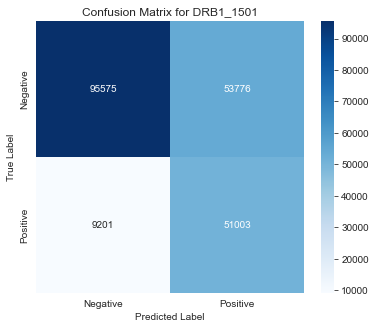

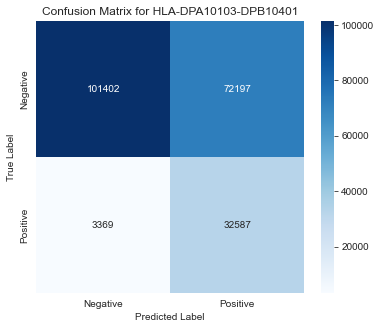

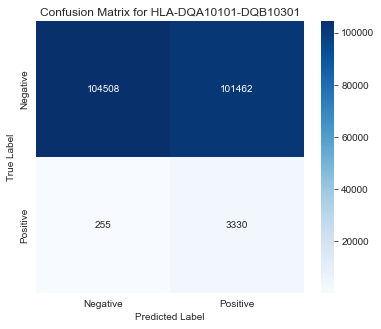

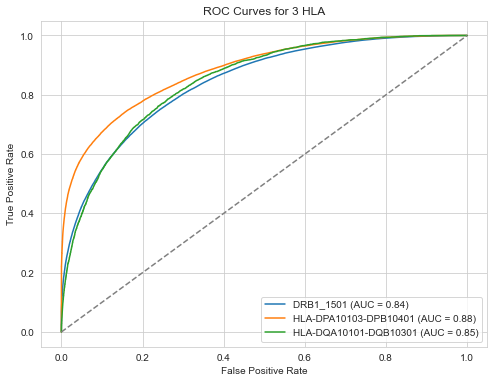

In [39]:
genes = ["DRB1_1501", "HLA-DPA10103-DPB10401", "HLA-DQA10101-DQB10301"]

gene_results = {}
y_true_dict = {}  # 分HLA保存y_true
metrics_results = {}

for gene in genes:
    # 选择该基因相关列
    subset = output_net[["Peptide", f"Rank_{gene}", f"nM_{gene}"]].dropna()
    
    # 设定真实标签：基于 nM 亲和力设定阈值，以500 nM 作为强结合的分界线
    subset["y_true"] = (subset[f"nM_{gene}"] <= 500).astype(int)  # 1 表示强结合，0 表示弱结合
    y_true_dict[gene] = subset["y_true"]
    
    # 使用 Rank 作为预测值，并取负值，因为 Rank 越小表示结合越强
    # 注：Rank 值较低表示更强的结合，因此在计算 ROC曲线时，要取 Rank 的负值，确保较大的预测值代表较强的结合
    y_true = subset["y_true"]
    y_scores = -subset[f"Rank_{gene}"]
    
    # 设定预测标签，使用 Rank 的中位数作为阈值
    threshold = subset[f"Rank_{gene}"].median()
    y_pred = (subset[f"Rank_{gene}"] <= threshold).astype(int)
    
    # 混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {gene}")
    plt.show()
    
    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # 存储结果
    gene_results[gene] = (fpr, tpr, roc_auc)
    metrics_results[gene] = {
        "AUC": roc_auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

plt.figure(figsize=(8, 6))
for gene, (fpr, tpr, roc_auc) in gene_results.items():
    plt.plot(fpr, tpr, label=f"{gene} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # 随机分类参考线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 3 HLA")
plt.legend(loc="lower right")
plt.show()

In [40]:
for gene, metrics in metrics_results.items():
    print(f"Metrics for {gene}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()

Metrics for DRB1_1501:
  AUC: 0.8407
  Accuracy: 0.6995
  Precision: 0.4868
  Recall: 0.8472
  F1-score: 0.6183

Metrics for HLA-DPA10103-DPB10401:
  AUC: 0.8812
  Accuracy: 0.6394
  Precision: 0.3110
  Recall: 0.9063
  F1-score: 0.4631

Metrics for HLA-DQA10101-DQB10301:
  AUC: 0.8462
  Accuracy: 0.5146
  Precision: 0.0318
  Recall: 0.9289
  F1-score: 0.0615



C:\Users\i\AppData\Local\Temp\ipykernel_12028\3930415223.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(x="HLA", y="Value", hue="Metric", data=df_melted,


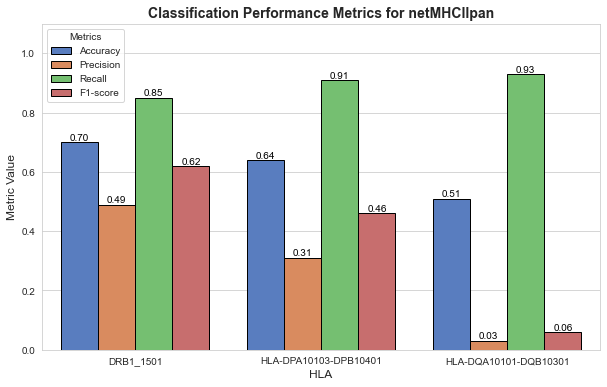

In [41]:
metrics_results = {
    "DRB1_1501": {"Accuracy": 0.70, "Precision": 0.49, "Recall": 0.85, "F1-score": 0.62},
    "HLA-DPA10103-DPB10401": {"Accuracy": 0.64, "Precision": 0.31, "Recall": 0.91, "F1-score": 0.46},
    "HLA-DQA10101-DQB10301": {"Accuracy": 0.51, "Precision": 0.03, "Recall": 0.93, "F1-score": 0.06},
}

df = pd.DataFrame(metrics_results).T
df = df.reset_index().rename(columns={"index": "HLA"})

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
df_melted = df.melt(id_vars=["HLA"], var_name="Metric", value_name="Value")

nice_palette = sns.color_palette("muted")  # 调色
ax = sns.barplot(x="HLA", y="Value", hue="Metric", data=df_melted,
                 palette=nice_palette, edgecolor="black")

for p in ax.patches:
    value = p.get_height()
    if value > 0.01:  # 过滤掉接近 0 的数值
        ax.annotate(f'{value:.2f}', 
                    (p.get_x() + p.get_width() / 2., value),
                    ha='center', va='bottom', fontsize=10, color="black")

plt.title("Classification Performance Metrics for netMHCIIpan", fontsize=14, fontweight="bold")
plt.xlabel("HLA", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title="Metrics", fontsize=10, loc="upper left")
plt.show()

pred

In [33]:
# 设定新的 HLA 名称映射关系（旧名 -> 新名）
hla_name_map = {
    "DRB1_1501": "DRB1_15_01",
    "HLA-DPA10103-DPB10401": "DPA1_01_03__DPB1_04_01",
    "HLA-DQA10101-DQB10301": "DQA1_01_01__DQB1_03_01"
}

# 创建新的字典，使用新的 HLA 名称作为 key
y_true_dict = {hla_name_map.get(old_key, old_key): df for old_key, df in y_true_dict.items()}

In [34]:
output_pred = pd.read_csv("E:/NTU/Course/6206/W10/new_input/output_pred_new.csv")

genes_pred = ["DRB1_15_01", "DQA1_01_01__DQB1_03_01", "DPA1_01_03__DPB1_04_01"]

# 确保 df_filtered 的 Epitope - Name 按照 output_pred["Peptide"] 的顺序排列
#df_filtered["Epitope - Name"] = pd.Categorical(df_filtered["Epitope - Name"], categories=output_pred["Peptide"], ordered=True)
#df_filtered = df_filtered.sort_values("Epitope - Name")
# 将 Assay - Qualitative Measurement 处理成 y_true（1: Positive, 0: Others）
#y_true = df_filtered["Assay - Qualitative Measurement"].str.contains("Positive", case=False, na=False).astype(int)

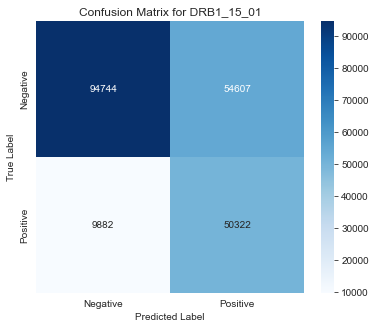

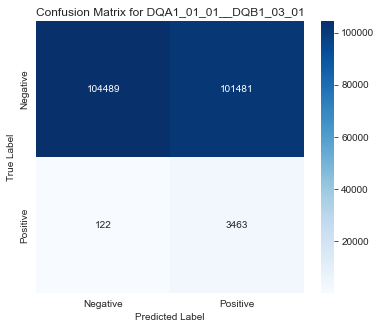

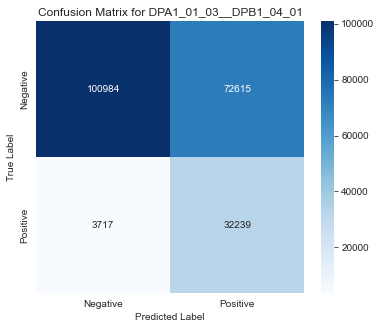

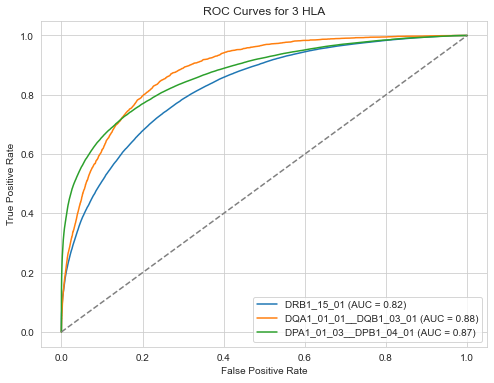

In [35]:
gene_results = {}
metrics_results = {}

for gene in genes_pred:
    rank_col = f"%Rank_{gene}"
    y_scores = output_pred[rank_col]
    y_true = y_true_dict[gene]

    threshold = y_scores.median()
    y_pred = (y_scores <= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {gene}")
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_true, -y_scores)  # 取负值确保较大值代表强结合
    roc_auc = auc(fpr, tpr)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    gene_results[gene] = (fpr, tpr, roc_auc)
    metrics_results[gene] = {
        "AUC": roc_auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

plt.figure(figsize=(8, 6))
colors = ["blue", "green", "orange"]
for gene, (fpr, tpr, roc_auc) in gene_results.items():
    plt.plot(fpr, tpr, label=f"{gene} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 3 HLA")
plt.legend(loc="lower right")
plt.show()

In [28]:
for gene, metrics in metrics_results.items():
    print(f"Metrics for {gene}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print()

Metrics for DRB1_15_01:
  AUC: 0.8249
  Accuracy: 0.6923
  Precision: 0.4796
  Recall: 0.8359
  F1-score: 0.6095

Metrics for DQA1_01_01__DQB1_03_01:
  AUC: 0.8811
  Accuracy: 0.5151
  Precision: 0.0330
  Recall: 0.9660
  F1-score: 0.0638

Metrics for DPA1_01_03__DPB1_04_01:
  AUC: 0.8697
  Accuracy: 0.6357
  Precision: 0.3075
  Recall: 0.8966
  F1-score: 0.4579



C:\Users\i\AppData\Local\Temp\ipykernel_12028\1160653712.py:16: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  ax = sns.barplot(x="HLA", y="Value", hue="Metric", data=df_melted,


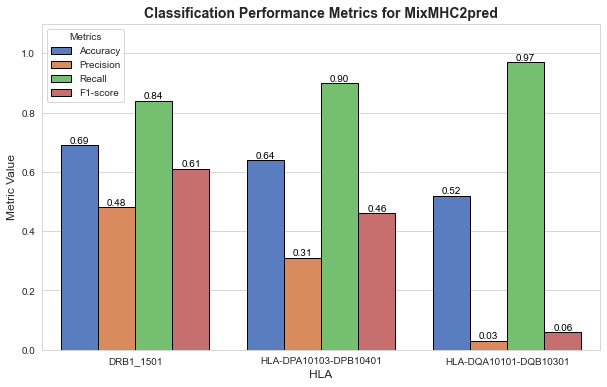

In [32]:
metrics_results = {
    "DRB1_1501": {"Accuracy": 0.69, "Precision": 0.48, "Recall": 0.84, "F1-score": 0.61},
    "HLA-DPA10103-DPB10401": {"Accuracy": 0.64, "Precision": 0.31, "Recall": 0.90, "F1-score": 0.46},
    "HLA-DQA10101-DQB10301": {"Accuracy": 0.52, "Precision": 0.03, "Recall": 0.97, "F1-score": 0.06},
}

df = pd.DataFrame(metrics_results).T
df = df.reset_index().rename(columns={"index": "HLA"})

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
df_melted = df.melt(id_vars=["HLA"], var_name="Metric", value_name="Value")

nice_palette = sns.color_palette("muted")
ax = sns.barplot(x="HLA", y="Value", hue="Metric", data=df_melted,
                 palette=nice_palette, edgecolor="black")

for p in ax.patches:
    value = p.get_height()
    if value > 0.01: 
        ax.annotate(f'{value:.2f}', 
                    (p.get_x() + p.get_width() / 2., value),
                    ha='center', va='bottom', fontsize=10, color="black")

plt.title("Classification Performance Metrics for MixMHC2pred", fontsize=14, fontweight="bold")
plt.xlabel("HLA", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title="Metrics", fontsize=10, loc="upper left")
plt.show()